In [2]:
from customerManager import CustomerManager
customer_path = "./config/customer_classes.json"
cManager = CustomerManager(file_path = customer_path)

In [8]:
import numpy as np
from scipy.special import erfc

class Learner():
    def __init__(self):
        self.n_arms = 10
        self.bid = np.linspace(1.0, 10.0, self.n_arms)
        self.t = 0 
        
        
        self.rewards_per_arm = x = [[] for i in range(self.n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward*10000)

class TS_Learner(Learner):
    def __init__(self, safety_t = 0.2):
        super().__init__()
        self.safety_t = safety_t
        #Mean and Std
        self.normal_parameters = np.zeros((self.n_arms, 2))

    def pull_arm(self):
        if self.t < (2*self.n_arms): return (self.t % self.n_arms) + 1

        #Safety constraint
        #Alternative implementation safety constraints using MATH         
        arg_max = []
        for p in self.normal_parameters : 
            if 0.5 * erfc(p[0]/(np.sqrt(2)*p[1])) > self.safety_t :
                arg_max.append(0.0) 
            else : 
                arg_max.append(np.random.normal(p[0], p[1]))
        

        return np.argmax(arg_max) + 1 #index Bid conversion

    def update(self, pulled_arm, reward):
        self.t += 1
        pulled_arm -= 1  #Bid index conversion
        times_pulled = max(1, len(self.rewards_per_arm[pulled_arm]))
        self.update_observations(pulled_arm, reward)
        #Empirical mean
        self.normal_parameters[pulled_arm, 0] = (self.normal_parameters[pulled_arm, 0] * (times_pulled - 1) + reward ) / times_pulled
        #Empirical std
        #NOt gooooood Should depend on the number of sampl (inversionally proportional)
        self.normal_parameters[pulled_arm, 1] = np.sqrt(sum((self.normal_parameters[pulled_arm, 0] - self.rewards_per_arm[pulled_arm])**2)/times_pulled)


In [9]:
opt_bids = [3.9416202240277745 , 3.0,  4.0]
opt_price = 7

In [10]:
from environment import Environment
from tqdm import tqdm

price = 5.0

T = 365
env = Environment(noise_variance= 0.20)
regret = []
ts_learner = TS_Learner()
ts_rewards_per_experiment = np.ndarray([])

regret=[]
sols = []

for t in tqdm(range(T)):
    #TS learner 
    bid = ts_learner.pull_arm()
    bids = [bid,bid,bid]
    sols.append(bid)
    reward = env.round(bids,price)
    ts_learner.update(bid, sum(reward)/10000)

    regret.append(sum(env.round(opt_bids, opt_price, noise = False)) - sum(reward))



100%|██████████| 365/365 [00:00<00:00, 807.66it/s]


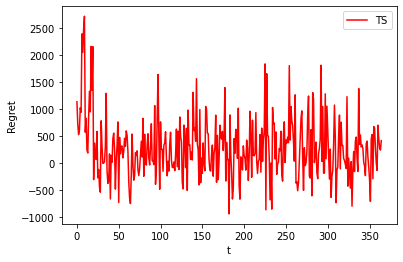

In [11]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(regret , 'r')
plt.legend(["TS" ])
plt.show()

In [12]:
sols[-10:]

[4, 4, 3, 4, 3, 3, 4, 4, 4, 4]